In [1]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

In [2]:
import hickle

from ase.io import read

import torch
torch.set_default_dtype(torch.float64)
import numpy as np

from mlelec.data.dataset import QMDataset
from mlelec.data.mldataset import MLDataset
from mlelec.models.linear_integrated import LinearModelPeriodic
from mlelec.utils._utils import blocks_to_matrix_opt as blocks_to_matrix
from mlelec.utils.twocenter_utils import _to_uncoupled_basis

import metatensor.torch as mts
from metatensor.learn import DataLoader

import xitorch
from xitorch.linalg import symeig

from matplotlib import pyplot as plt

from IPython.utils import io as ipy_io


/home/nigam/miniconda3/envs/py312/lib/python3.12/site-packages/pyscf/dft/libxc.py:772: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, the same to the B3LYP functional in Gaussian and ORCA (issue 1480). To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [3]:
orbitals = {
    'sto-3g': {1: [[1,0,0]], 
               5: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]], 
               6: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]], 
               7: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]],
               8: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]]
               }, 
    
    'def2svp': {1: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]],
                6: [[1,0,0],[2,0,0],[3,0,0],[2,1,1], [2,1,-1],[2,1,0], [3,1,1], [3,1,-1],[3,1,0], [3,2,-2], [3,2,-1],[3,2,0], [3,2,1],[3,2,2]],
                8: [[1,0,0],[2,0,0],[3,0,0],[2,1,1], [2,1,-1],[2,1,0], [3,1,1], [3,1,-1],[3,1,0], [3,2,-2], [3,2,-1],[3,2,0], [3,2,1],[3,2,2]]
                },
}

device = 'cpu'

In [53]:
workdir = '../examples/data/water_1000'
nstruc = 20
frames = read(f'{workdir}/water_1000.xyz',f':{nstruc}')
fock = hickle.load(f'{workdir}/sto-3g/fock.hickle')[:nstruc]
over = hickle.load(f'{workdir}/sto-3g/overlap.hickle')[:nstruc]

In [54]:
qmdata = QMDataset(frames = frames, 
                   kmesh = [1,1,1], 
                   fix_p_orbital_order=True,
                   dimension = 0,
                   fock_realspace=fock,
                   overlap_realspace=list(over),
                   device = device, 
                   orbs = orbitals['sto-3g'], 
                   orbs_name = 'sto-3g'
                )

In [55]:
max_radial  = 8
max_angular = 4
atomic_gaussian_width = 0.3
cutoff = 3.5

hypers_pair = {'cutoff': cutoff,
               'max_radial': max_radial,
               'max_angular': max_angular,
               'atomic_gaussian_width': atomic_gaussian_width,
               'center_atom_weight': 1,
               "radial_basis": {"Gto": {}},
               "cutoff_function": {"ShiftedCosine": {"width": 0.5}}}

hypers_atom = {'cutoff': 4,
               'max_radial': max_radial,
               'max_angular': max_angular,
               'atomic_gaussian_width': 0.5,
               'center_atom_weight': 1,
               "radial_basis": {"Gto": {}},
               "cutoff_function": {"ShiftedCosine": {"width": 0.5}}}


return_rho0ij = False
both_centers = False
LCUT = 3

In [56]:
mldata = MLDataset(qmdata, 
                   item_names = ['overlap_blocks', 'fock_blocks', 'fock_realspace', 'overlap_realspace', 'eigenvalues', 'atom_resolved_density'],
                   features = None,#mldata.features,
                   cutoff = hypers_pair['cutoff'],
                   hypers_atom = hypers_atom,
                   hypers_pair = hypers_pair,
                   lcut = 3,
                   orbitals_to_properties = True,
                  )

cpu pair features
cpu single center features
cpu single center features
Features set
Items set


In [57]:
overlap_uncoupled = _to_uncoupled_basis(mldata.items['overlap_blocks'])
fock_uncoupled = _to_uncoupled_basis(mldata.items['fock_blocks'])

In [96]:
def rnd_spherical_target(S, nout = 1, return_tensormap = False, qmdata = None):
    '''
    Create random tensor multiplying the blocks of S by random numbers
    '''
    tmaps = []
    for i in range(nout):
        # c = torch.normal(0, 10, (len(S),), dtype = torch.float64)
        c = torch.randn(len(S), dtype = torch.float64)*4e-2
        blocks_ = []
        for i, (k, b) in enumerate(S.items()):
            n = max(b.values.norm(), 1e-12)
            blocks_.append(
                mts.TensorBlock(
                    values = b.values* c[i], #/ n,
                    samples = b.samples,
                    properties = b.properties,
                    components = b.components
                )
            )
        tmaps.append(mts.TensorMap(S.keys, blocks_))

    if return_tensormap:
        return tmaps
    else:
        mats = []
        for tmap in tmaps:
            mat = blocks_to_matrix(tmap, qmdata, detach = True)
            if qmdata._ismolecule:
                mat = [m[0,0,0] for m in mat]
                try:
                    mat = torch.stack(mat)
                except:
                    pass
            mats.append(mat)
        try:
            return torch.stack(mats)
        except RuntimeError:
            return mats

In [97]:
mldata._split_indices(train_frac = 0.8, val_frac = 0.2)
mldata._split_items(mldata.train_frac, mldata.val_frac, mldata.test_frac)

In [98]:
dl = DataLoader(mldata.train_dataset, batch_size = 8, collate_fn = mldata.group_and_join)

In [99]:
from mlelec.metrics import Eigval_loss, L2_loss_meanzero, L2_loss
loss_fn = Eigval_loss #L2_loss #_meanzero

In [106]:
n = 100
targets = rnd_spherical_target(fock_uncoupled, nout=n, qmdata=qmdata)
targets = torch.einsum('Nij,nNjl->Nnil', torch.linalg.inv(torch.stack(mldata.items['overlap_realspace'])), targets)

In [107]:
eig_var = torch.cat([m.flatten() for m in mldata.items['eigenvalues']]).norm()**2
tar_var = torch.einsum('Nji,Nnij->Nn', torch.stack(mldata.items['density_matrix']).real, targets).norm()**2

In [108]:
def compute_eigval_vec(dataset, batch, Hk, return_rho = False):
    eig = []
    rho = []
    for A, H, S in zip(batch.sample_id, Hk, batch.overlap_realspace):
        # Compute eigenvalues and eigenvectors
        # eigvals, eigvecs = symeig(Ax, M = Mx)
        eigvals, C = symeig(xitorch.LinearOperator.m(H), M = xitorch.LinearOperator.m(S))
        if return_rho:
            frame = dataset.structures[A]
            natm = len(frame)
            ncore = sum(dataset.ncore[s] for s in frame.numbers)
            nelec = sum(frame.numbers) - ncore
            occ = torch.tensor([2.0 if i <= nelec//2 else 0.0 for i in range(C.shape[-1])], dtype = torch.float64, requires_grad = True, device = device)
            rho.append(torch.einsum('n,...in,...jn->ij...', occ, C, C.conj()))
        eig.append(eigvals)
    if return_rho:
        return eig, rho
    else:
        return eig

def compute_ard_vec(dataset, batch, HT, device):
    basis = dataset.basis
    ard_ = []
    eig = []
    
    for A, H, S in zip(batch.sample_id, HT, batch.overlap_realspace):
        frame = dataset.structures[A]
        natm = len(frame)
        ncore = sum(dataset.ncore[s] for s in frame.numbers)
        nelec = sum(frame.numbers) - ncore
        split_idx = [len(basis[s]) for s in frame.numbers]
        needed = True if len(np.unique(split_idx)) > 1 else False
        
        max_dim = np.max(split_idx)
        
        eigvals, C = symeig(xitorch.LinearOperator.m(H), M=xitorch.LinearOperator.m(S), return_eigenvectors = True) # Has shape = (n_k, N, N)
        
        occ = torch.tensor([2.0 if i <= nelec//2 else 0.0 for i in range(C.shape[-1])], dtype = torch.float64, requires_grad = True, device = device)
        P = torch.einsum('n,...in,...jn->ij...', occ, C, C.conj())

        slices = torch.split(P, split_idx, dim=0)
        blocks = [torch.split(slice_, split_idx, dim=1) for slice_ in slices]
        blocks_flat = [block for sublist in blocks for block in sublist]
        
        if needed:
            squared_blocks = []
            for block in blocks_flat:
                pad_size = (0, max_dim - block.size(1), 0, max_dim - block.size(0))
                squared_block = torch.nn.functional.pad(block, pad_size, "constant", 0)
                squared_blocks.append(squared_block)
            blocks_flat = squared_blocks


        ard_.append(torch.stack(blocks_flat).norm(dim=(1,2)))
        eig.append(eigvals)
    
    return eig, ard_

In [119]:
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)

model = LinearModelPeriodic(twocfeat = mldata.features, 
                            target_blocks = mldata.model_metadata,
                            frames = qmdata.structures, 
                            orbitals = qmdata.basis, 
                            device = device,
                            nhidden = 8, 
                            nlayers = 1,
                            activation = 'SiLU',
                            apply_norm = True
                           )
model = model.double()
NEPOCHS = 0

In [120]:
optimizer = torch.optim.Adam(model.parameters(), lr = 5e-3, weight_decay = 1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.8, patience = 20)

# TRAIN (if neeeeeeded)

In [121]:
nepoch = 1000
losses = []
losses_e = []
losses_t = []
par = 0.5
alpha = 1 #(1 + par)
beta = 1 #(1 - par**2)
for epoch in range(NEPOCHS,NEPOCHS+nepoch):

    epoch_loss = 0
    epoch_loss_e = 0
    epoch_loss_t = 0

    

    # Train against real space targets
    for ib, batch in enumerate(dl):
        
        model.train(True)
        optimizer.zero_grad()
        
        pred = model.forward(batch.features, mldata.model_metadata)
        HT = blocks_to_matrix(pred, qmdata, detach = False, structure_ids=batch.sample_id)
        HT = [h[0,0,0] for h in HT]
        
        # pred_eigvals = compute_eigval_vec(qmdata, batch, HT, return_rho=False)
        pred_eigvals, pred_rho = compute_eigval_vec(qmdata, batch, HT, return_rho=True)
        trace_loss = sum((torch.einsum('ji...,nij...->n...', pred_rho[Ab] - batch.density_matrix[Ab].real, targets[A])**2).sum() for Ab, A in enumerate(batch.sample_id)) #/tar_var
        loss_e = loss_fn(pred_eigvals, batch.eigenvalues) #/eig_var
        
        epoch_loss_e += loss_e.item()
        epoch_loss_t += trace_loss.item()
        # loss = loss_e + trace_loss 
        loss = alpha*loss_e + beta*trace_loss #  + loss_fn(pred_ard, batch.atom_resolved_density)
        # loss = loss_e/(epoch_loss_e*5e-1) + trace_loss/(epoch_loss_t*8e-1)
        # loss = trace_loss/(epoch_loss_t*5e-2)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
        # torch.nn.utils.clip_grad_norm_(model.parameters(),1)
    # par = epoch_loss_e/2/epoch_loss_t
    # alpha = (1 + par) if epoch_loss_e > epoch_loss_t else (1 - par**2)
    # beta = (1 + par) if epoch_loss_e <= epoch_loss_t else (1 - par**2)
    # par = epoch_loss_e/2/epoch_loss_t if epoch_loss_e > epoch_loss_t else epoch_loss_t/2/epoch_loss_e
    # alpha = 1+par
    # if epoch>100:
    #     alpha = epoch/1000
    # beta = 1-par**2
    # if epoch ==0: 
    #     alpha = 1/epoch_loss_e 
    #     beta = 1/epoch_loss_t
    scheduler.step(epoch_loss)
    losses.append(epoch_loss)
    losses_e.append(epoch_loss_e)
    losses_t.append(epoch_loss_t)
    
    if epoch >= 0: #% 10 == 0:
        print(f"Epoch {epoch:>7d}, train loss {epoch_loss:>15.10f} {epoch_loss_e:>15.10f} {epoch_loss_t:>15.10f} {par:>15.10f}")
        # print(f"Epoch {epoch:>7d}, train loss {np.sqrt(epoch_loss):>15.10f} {np.sqrt(epoch_loss_e):>15.10f} {np.sqrt(epoch_loss_t):>15.10f} {par:>15.10f} {}")

Epoch       0, train loss 7329.3760345638 6506.5394955043  822.8365390595    0.5000000000
Epoch       1, train loss 6341.0438971368 6171.8931913774  169.1507057594    0.5000000000
Epoch       2, train loss 6049.4754684005 5876.1995020581  173.2759663424    0.5000000000
Epoch       3, train loss 5722.1918915948 5541.7476233561  180.4442682387    0.5000000000
Epoch       4, train loss 5390.9498419599 5204.2041583806  186.7456835794    0.5000000000
Epoch       5, train loss 5053.0548159285 4865.1678152323  187.8870006962    0.5000000000
Epoch       6, train loss 4709.3128627413 4523.6758482213  185.6370145200    0.5000000000
Epoch       7, train loss 4363.3428634380 4181.2424171102  182.1004463278    0.5000000000
Epoch       8, train loss 4019.5902253362 3840.9710849107  178.6191404255    0.5000000000
Epoch       9, train loss 3681.3722168580 3505.7114994608  175.6607173972    0.5000000000
Epoch      10, train loss 3353.1101060767 3179.8859317245  173.2241743521    0.5000000000
Epoch     

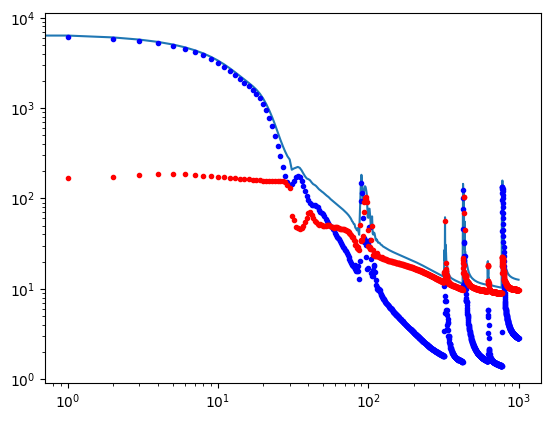

In [122]:
plt.loglog(losses)
plt.loglog(losses_e, 'b.')
plt.loglog(losses_t, 'r.')

# Validate

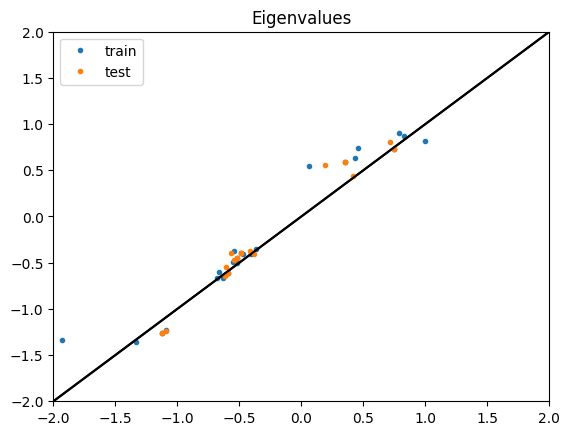

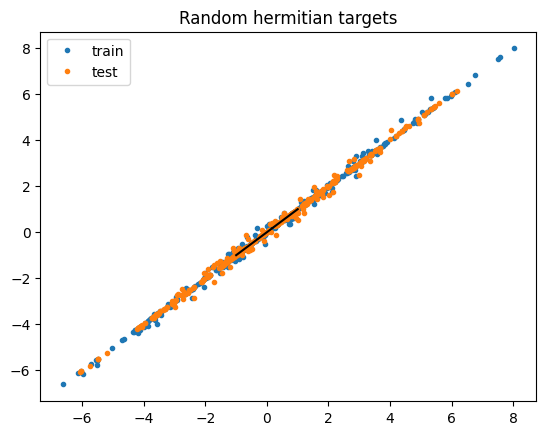

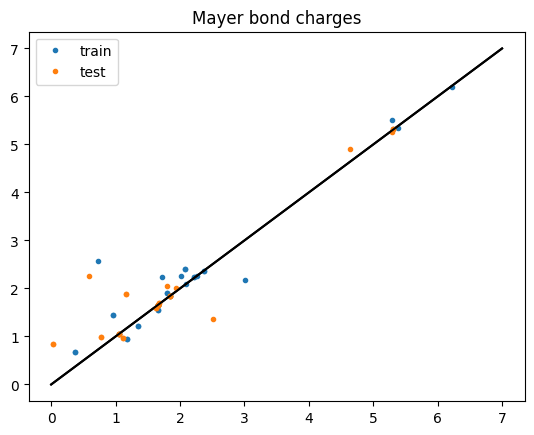

In [123]:
# n = 100
# targets = [rnd_herm(n, f.shape[0]) for f in mldata.items['fock_realspace']] 

val_dl = DataLoader(mldata.val_dataset, batch_size = len(mldata.val_dataset), collate_fn=mldata.group_and_join)
train_dl = DataLoader(mldata.train_dataset, batch_size = len(mldata.val_dataset), collate_fn=mldata.group_and_join)

fig_e, ax_e = plt.subplots()
fig_r, ax_r = plt.subplots()
fig_a, ax_a = plt.subplots()

data = {}
for dl_, lbl in zip([train_dl, val_dl], ['train', 'test']):
    batch = next(iter(dl_))
    pred = model(batch.features, mldata.model_metadata)

    HT = blocks_to_matrix(pred, qmdata, detach = True, structure_ids=batch.sample_id)
    HT = [h[0,0,0] for h in HT]
    pred_eigvals, pred_rho = compute_eigval_vec(qmdata, batch, HT, return_rho=True)

    pred_trace = torch.cat([torch.einsum('ij...,nji...->n...', pred_rho[Ab].detach(), targets[A]) for Ab, A in enumerate(batch.sample_id)])
    true_trace = torch.cat([torch.einsum('ij...,nji...->n...', batch.density_matrix[Ab].detach().real, targets[A]) for Ab, A in enumerate(batch.sample_id)])

    ax_r.plot(true_trace, pred_trace, '.', label = lbl)
    ax_r.plot([-1,1], [-1, 1], 'k')
    ax_r.set_title('Random hermitian targets')
    ax_r.legend()

    ax_e.plot(torch.cat(pred_eigvals).detach(), batch.eigenvalues.flatten(), '.', label = lbl)
    ax_e.plot([-21, 2], [-21, 2], 'k')
    ax_e.set_xlim(-2,2)
    ax_e.set_ylim(-2,2)
    ax_e.set_title('Eigenvalues')
    ax_e.legend()

    pred_eig, pred_ard = compute_ard_vec(qmdata, batch, HT, device)
    ax_a.plot(batch.atom_resolved_density.flatten(), torch.stack(pred_ard).detach().flatten(), '.', label = lbl)
    ax_a.plot([0,7], [0,7], 'k')
    ax_a.set_title('Mayer bond charges')
    ax_a.legend()

# Dipole 

In [124]:
import os

os.environ["PYSCFAD_BACKEND"] = "torch"

import torch
from pyscf import gto

from pyscfad import numpy as pynp
from pyscfad import ops
from pyscfad.ml.scf import hf
import pyscf.pbc.tools.pyscf_ase as pyscf_ase
from mlelec.data.pyscf_calculator import _instantiate_pyscf_mol
from mlelec.utils.twocenter_utils import fix_orbital_order, unfix_orbital_order

In [125]:
def compute_dipole_moment(frames, fock_predictions, overlaps):
    assert (
        len(frames) == len(fock_predictions) == len(overlaps)
    ), "Length of frames, fock_predictions, and overlaps must be the same"
    dipoles = []
    for i, frame in enumerate(frames):
        mol = _instantiate_pyscf_mol(frame)
        mf = hf.SCF(mol)
        fock = torch.autograd.Variable(
            fock_predictions[i].type(torch.float64), requires_grad=True
        )

        mo_energy, mo_coeff = mf.eig(fock, overlaps[i])
        mo_occ = mf.get_occ(mo_energy)  # get_occ returns a numpy array
        mo_occ = ops.convert_to_tensor(mo_occ)
        dm1 = mf.make_rdm1(mo_coeff, mo_occ)
        dip = mf.dip_moment(dm=dm1)
        dipoles.append(dip)
    return torch.stack(dipoles)

In [126]:
batch = next(iter(val_dl))
pred = model(batch.features, mldata.model_metadata)

HT = blocks_to_matrix(pred, qmdata, detach = True, structure_ids=batch.sample_id)
HT = [h[0,0,0] for h in HT]

fock_predictions = torch.stack(HT)
fock_predictions = unfix_orbital_order(
    fock_predictions,
    mldata.val_frames,
    mldata.qmdata.basis,
)

In [127]:
# train_dl = DataLoader(mldata.train_dataset, batch_size = len(mldata.val_dataset), collate_fn=mldata.group_and_join)

batch = next(iter(train_dl))
dl_frames = [qmdata.structures[A] for A in batch.sample_id]

pred = model(batch.features, mldata.model_metadata)

HT = blocks_to_matrix(pred, qmdata, detach = True, structure_ids=batch.sample_id)
HT = [h[0,0,0] for h in HT]

fock_predictions = torch.stack(HT)

fock_predictions = unfix_orbital_order(
    fock_predictions,
    dl_frames,
    mldata.qmdata.basis,
)

fock_targets = unfix_orbital_order(
    batch.fock_realspace,
    dl_frames,
    mldata.qmdata.basis,
)

over_realspace = unfix_orbital_order(
    batch.overlap_realspace,
    dl_frames,
    mldata.qmdata.basis,
)

with ipy_io.capture_output():
    dipole_targets = compute_dipole_moment(
        dl_frames,
        fock_targets,
        over_realspace,
    )

with ipy_io.capture_output():
    dipole_predictions = compute_dipole_moment(
        dl_frames,
        fock_predictions,
        over_realspace,
    )

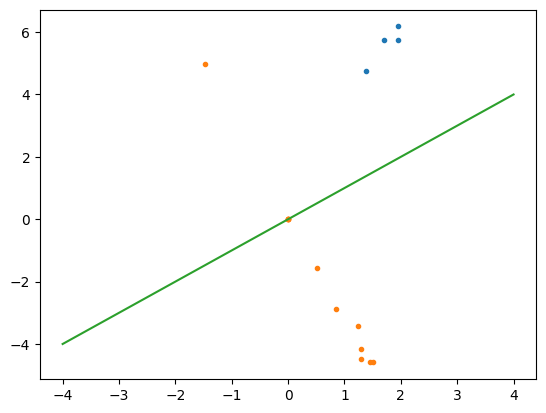

In [132]:
i = 2
plt.plot(dipole_targets.norm(dim=1).flatten().detach().cpu(), dipole_predictions.norm(dim=1).flatten().detach().cpu(), '.')
# plt.plot(dipole_targets[:,i].flatten().detach().cpu(), dipole_predictions[:,i].flatten().detach().cpu(), '.')
plt.plot(dipole_targets.flatten().detach().cpu(), dipole_predictions.flatten().detach().cpu(), '.')
plt.plot([-4,4], [-4,4])

In [133]:
pred_eigvals, pred_rho = compute_eigval_vec(qmdata, batch, HT, return_rho=True)

In [134]:
# pred_band_e = torch.einsum('Nij,Nji->N', torch.stack(HT), torch.stack(pred_rho)).detach()
pred_band_e = torch.einsum('Nij,Njk,Nki->N', batch.fock_realspace, torch.linalg.inv(batch.overlap_realspace), torch.stack(pred_rho)).detach()

In [135]:
# target_band_e = torch.einsum('Nij,Nji->N', batch.fock_realspace, batch.density_matrix.real).detach()
target_band_e = torch.einsum('Nij,Njk,Nki->N', batch.fock_realspace, torch.linalg.inv(batch.overlap_realspace), batch.density_matrix.real).detach()

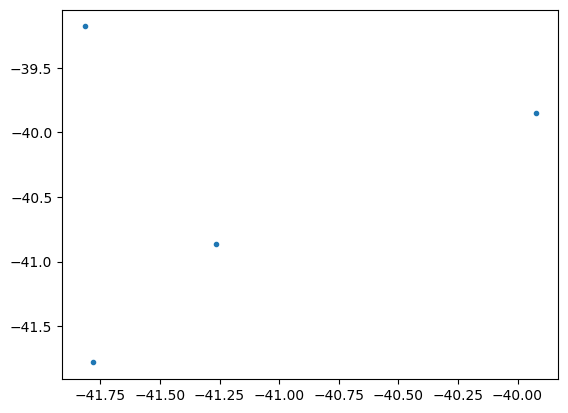

In [136]:
plt.plot(target_band_e, pred_band_e, '.')
# plt.plot([-46,-38], [-46,-38])

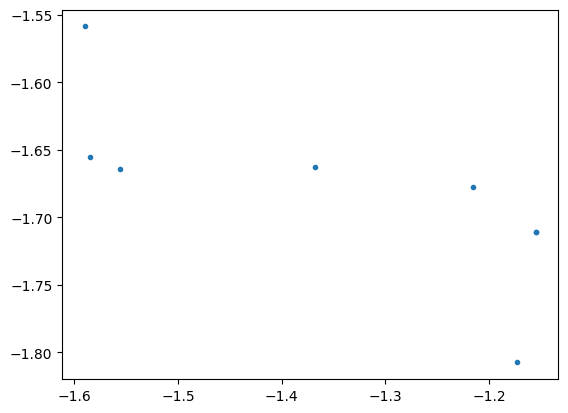

In [137]:
plt.plot(batch.fock_blocks[5].values[...,0], pred[5].values[...,0].detach(), '.')

In [138]:
from mlelec.utils.pbc_utils import matrix_to_blocks

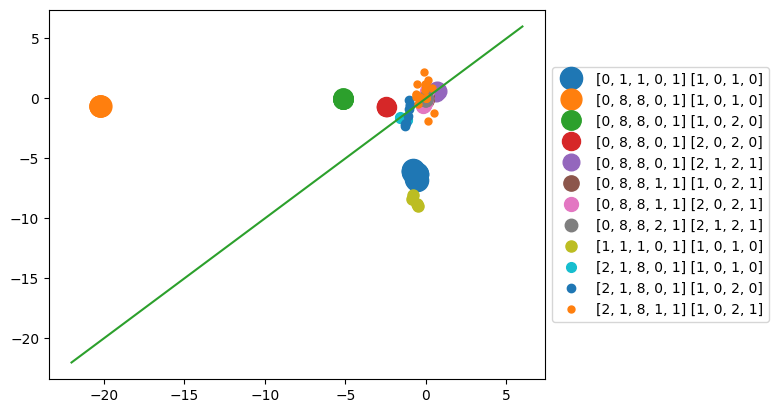

In [139]:
s = 16
for (k, b1), b2 in zip(batch.fock_blocks.items(), pred.blocks()):
    for p, underscore in enumerate(b1.properties):
        plt.plot(b1.values[:,:,p].flatten(), b2.values[:,:,p].detach().flatten(), 'o', markersize = s,  label = f'{k.values.tolist()} {underscore.values[:-1].tolist()}')
        s -= 1
plt.legend(loc = 'center left', bbox_to_anchor = (1,.5))
plt.plot([-22, 6], [-22, 6])
# plt.xlim(-2,2)
# plt.ylim(-2,2)

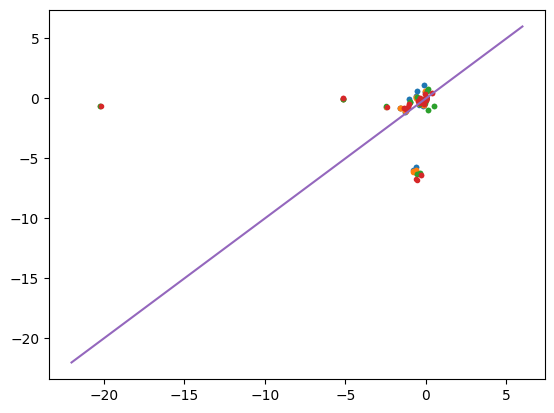

In [140]:
for h1, h2 in zip(batch.fock_realspace, torch.stack(HT)):
    # plt.plot(h2.flatten(), '.')
    plt.plot(h1.flatten(), h2.flatten(), '.')
plt.plot([-22, 6], [-22, 6])

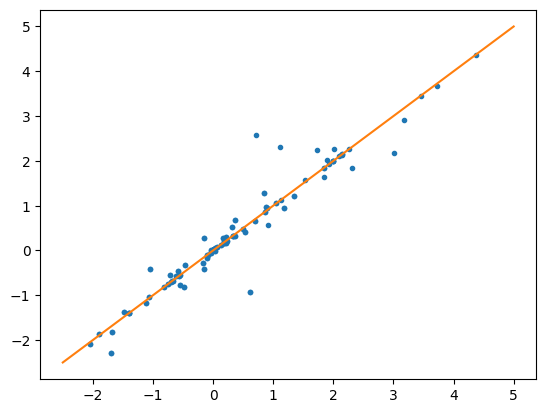

In [141]:
plt.plot(batch.density_matrix.real.flatten(), torch.stack(pred_rho).detach().flatten(), '.')
plt.plot([-2.5, 5], [-2.5, 5])